Using TensorFlow backend.


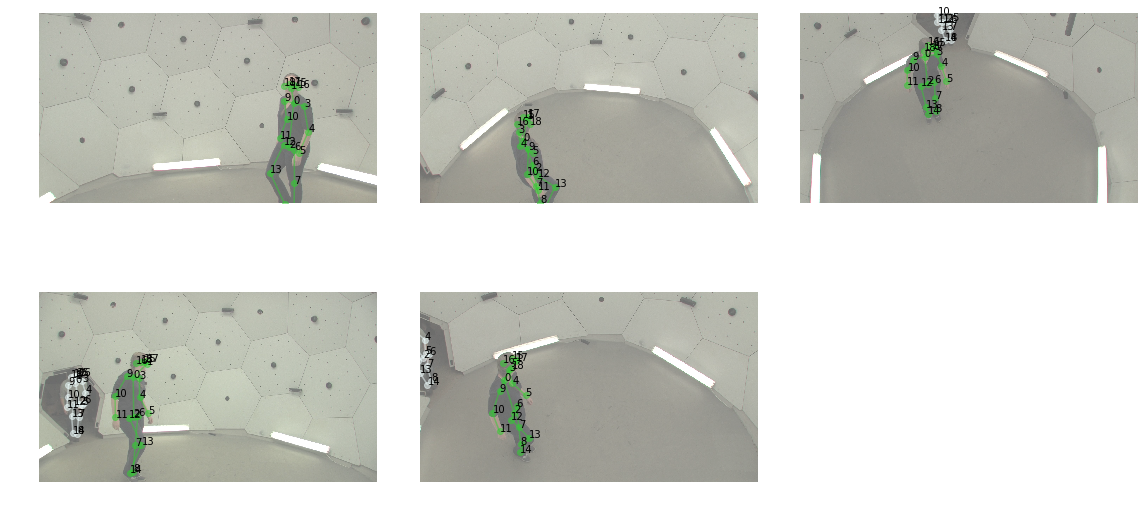

In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
sys.path.insert(0,'../debugging')
from mvpose.data import epfl_campus
from time import time

root = Settings['CMU']['data_root']
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d
from mvpose.data import cmu_panoptic
from cselect import color as cs
from random import shuffle


from openpose import OpenPose

loader = Loader(with_gpu=True)

FRAME = 8642

nodes = [0, 1, 2, 3, 4]
panels = [0, 0, 0, 0, 0]
#seq_name = '160224_haggling1'
seq_name = '160422_ultimatum1'

Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)

fig = plt.figure(figsize=(16,8))

# Edges between joints in the body skeleton
body_edges = np.array([[1,2],[1,4],[4,5],[5,6],[1,3],[3,7],[7,8],[8,9],[3,13],[13,14],[14,15],[1,10],[10,11],[11,12]])-1


colors = ['red', 'blue', 'yellow', 'cyan', 'orange', 
          'teal', 'white', 'cornflowerblue', 'limegreen',
         'rosybrown', 'sienna', 'plum', 'slategrey',
         'orchid', 'lightblue', 'azure', 'aliceblue',
         'darkblue', 'lightcoral', 'silver', 'mediumpurple',
         'lightskyblue']
shuffle(colors)

# n = 18
# colors = cs.rangecolor(n, (255, 0, 0), (0, 256, 0))/255

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(2,3,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    ax.set_xlim([0, 1920])
    ax.set_ylim([1080, 0])
#     ax.set_xlim([1200, 1800])
#     ax.set_ylim([1080, 300])
    
    for pid, points3d_weighted in Y:
        pts3d = points3d_weighted[:, 0:3].astype('float32')
        pts2d = cam.projectPoints(pts3d)
        pts2dT = pts2d.transpose()
        ax.scatter(pts2d[:, 0], pts2d[:, 1], color=colors[pid], alpha=0.5)
        for edge in body_edges:
            ax.plot(pts2dT[0, edge], pts2dT[1, edge],
                    color=colors[pid], alpha=0.5)
        for idx, (x, y) in enumerate(pts2d):
            if x >= 0 and x < w:
                if y >= 0 and y < h:
                    ax.text(x, y, str(idx))
        
    
plt.tight_layout()

plt.show()

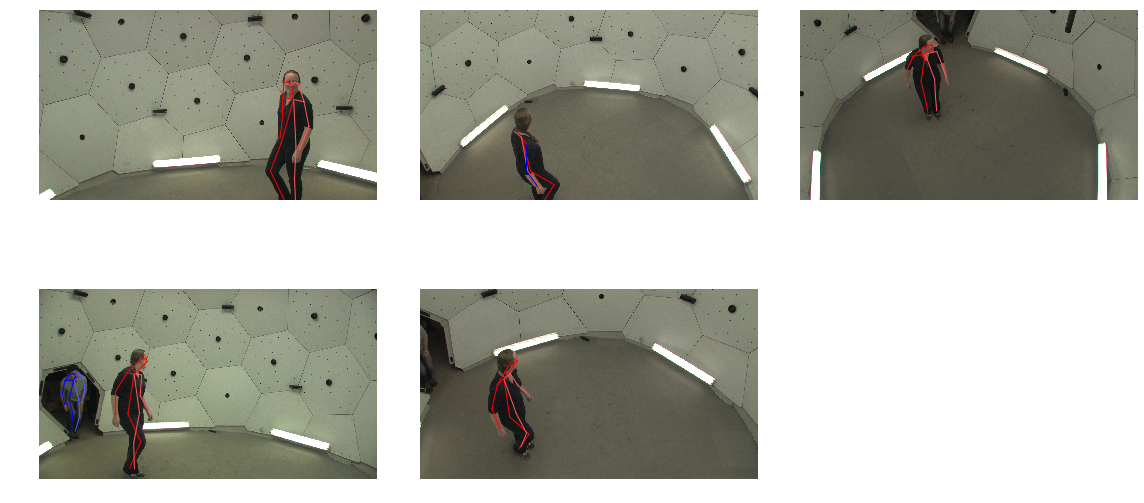

In [2]:
pe = OpenPose(tmp=tmp)
predictions = pe.predict(Im, 'cvpr_cmu' + seq_name, FRAME)

colors = ['red', 'blue', 'green', 'yellow', 'teal', 'magenta']

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fig = plt.figure(figsize=(16, 8))
for idx, (im, pred) in enumerate(zip(Im, predictions)):
    ax = fig.add_subplot(2, 3, idx+1); ax.axis('off')
    ax.imshow(im)
    ax.set_xlim([0, 1920])
    ax.set_ylim([1080, 0])
    
    for pid, human in enumerate(pred):
        draw_mscoco_human2d(ax, human[:, 0:2], color=colors[pid])

    
plt.tight_layout()
plt.show()

In [3]:
def calculate_pcp_score(Y, detections):
    alpha = 0.5
    Humans = kth.transform3d_from_mscoco(detections)
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
    
    Y_kth = []
    for _, gt in Y:
        Y_kth.append(gt[:, 0:3])
    Y_kth = kth.transform3d_from_mscoco(Y_kth)
        
    for gtid, gt in enumerate(Y_kth):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs
        
def print_pcp(L_Arms, U_Arms, L_Legs, U_Legs, GTIDs):
    print("")
    for la, ua, ll, ul, gid in zip(L_Arms, U_Arms, L_Legs, U_Legs, GTIDs):
        print('gtid:', gid)
        print('\tla:', la)
        print('\tua:', ua)
        print('\tll:', ll)
        print('\tul:', ul)
    
    print('avg')
    print('\tla:', np.mean(L_Arms))
    print('\tua:', np.mean(U_Arms))
    print('\tll:', np.mean(L_Legs))
    print('\tul:', np.mean(U_Legs))
    print("\n\tavg*:", np.mean([
        np.mean(L_Arms), np.mean(U_Arms), 
        np.mean(L_Legs), np.mean(U_Legs)
    ]))

In [4]:
import numpy.linalg as la
from scipy.optimize import linear_sum_assignment

def calculate_closeness(y, y_pred):
    scale_to_mm = 10
    assert len(y) == 18
    assert len(y_pred) == 18
    y = y[:, 0:3]
    n = 0
    distances = []
    for jid, (a, b) in enumerate(zip(y, y_pred)):
        if b is None:
            continue
        d = la.norm(a-b) * scale_to_mm
        distances.append(d)
    return np.squeeze(np.mean(distances))


def find_closest_detections_to_gt(Y, humans):
    n = len(Y)
    m = len(humans)
    C = np.zeros((n, m))
    
    print('#gt:', n)
    print('#d:', m)
    
    for i in range(n):
        for j in range(m):
            C[i, j] = calculate_closeness(Y[i][1], humans[j])
    
    scores = []
    rows, cols = linear_sum_assignment(C)
    for gt_id, pr_id in zip(rows, cols):
        scores.append(C[gt_id, pr_id])
    return scores

In [78]:
FRAME = 112
seq_name = '160906_pizza1'

step 1: elapsed 3.232034683227539
step 2: elapsed 0.03327775001525879
step 3: elapsed 0.9414036273956299
step 4: elapsed 3.8684961795806885
-------------------------------------------
Handle transitivity:
	Intra:		 0
	Intra(choice):	 0
	Inter:		 0
	Inter(choice):	 185
-------------------------------------------
	Time =  38  ms
	result: 0

	Total cost: 91.88139727449258

# valid points:		 133
# invalid points:	 21
step 5: elapsed 0.04460310935974121
(smart candidate selection) [
	Time =  7  ms
	result: 0

	Total cost: 44.97521669388597
] (smart candidate selection)
step 6: elapsed 0.02857232093811035

total elapsed: 8.149183511734009
#Humans 4
#gt: 4
#d: 4

-- best fit --
[27.49379990331598, 18.468203739033317, 53.78360442944409, 76.44163529072297]
	min: 18.468203739033317
	max: 76.44163529072297
	avg: 44.04681084062909


gtid: 0
	la: 1.0
	ua: 1.0
	ll: 1.0
	ul: 1.0
gtid: 1
	la: 1.0
	ua: 1.0
	ll: 1.0
	ul: 1.0
gtid: 2
	la: 0.5
	ua: 0.5
	ll: 1.0
	ul: 1.0
gtid: 3
	la: 0.5
	ua: 1.0
	ll: 0.5


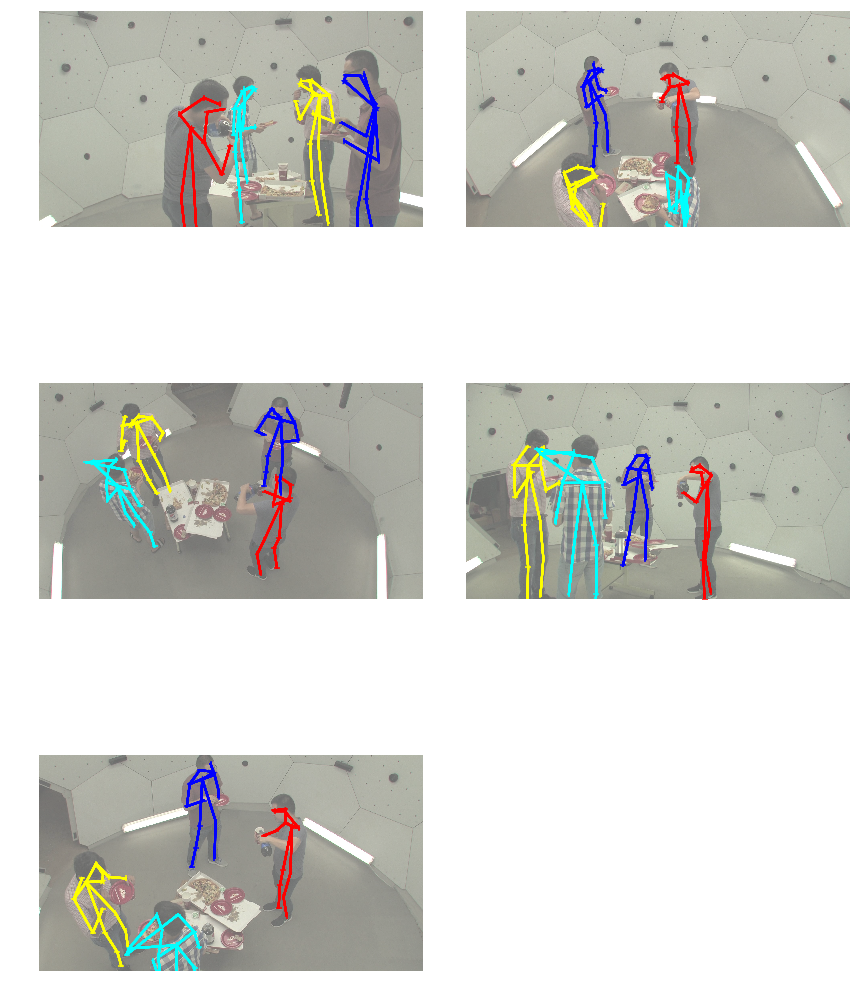

In [79]:
from mvpose import settings
import paf_loader
from mvpose import pose
from mvpose.plot.limbs import draw_mscoco_human

Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)
Y = cmu_panoptic.transform_y(Y)

# -- remove cameras --
# Im = Im[0:3]
# Y = Y[0:3]
# Calib = Calib[0:3]
# -- {end} remove cameras --

params = settings.get_settings(
    max_epi_distance=40, 
    scale_to_mm=10, 
    gp_max_radius=30,
    pp_conflict_overlap=0.6)

# -- we always use gpu --
assert loader.with_gpu
heatmaps, pafs = loader.load_confidence_map_and_paf('cmu' + seq_name, 
                                                        Im, FRAME,
                                                        dir=tmp)

_start = time()
Debug, detections = pose.estimate(
    Calib, heatmaps, pafs, settings=params, debug=True)
_end = time()
print('\ntotal elapsed:', _end - _start)

Humans = detections
print("#Humans", len(Humans))

fig = plt.figure(figsize=(12,16))

colors = ['red', 'blue', 'yellow', 'cyan', 'orange', 
          'teal', 'white', 'cornflowerblue', 'limegreen']

for idx, cam in enumerate(Calib):
    ax = fig.add_subplot(3,2,1+idx)
    ax.axis('off')
    im = Im[idx]
    h,w,_ = im.shape
    ax.imshow(im, alpha=0.6)
    ax.set_xlim([0, 1920])
    ax.set_ylim([1080, 0])
    
    for pid, human in enumerate(Humans):
        draw_mscoco_human(ax, human, cam, color=colors[pid], linewidth=2)
    
# ===
closest = find_closest_detections_to_gt(Y, Humans)
print('')
print('-- best fit --')
print(closest)
print('\tmin: ' + str(np.min(closest))) 
print('\tmax: ' + str(np.max(closest)))
print('\tavg: ' + str(np.mean(closest)))

print('')

print_pcp(*calculate_pcp_score(Y, Humans))

print('\n(GRAPH PARTITIONING)')

plt.tight_layout()
plt.show()

elapsed 0.2192845344543457
#d 7
#gt: 4
#d: 7

-- best fit --
[25.477168689105174, 19.79357910921876, 38.470412711091186, 57.21165911004399]
	min: 19.79357910921876
	max: 57.21165911004399
	avg: 35.23820490486478


gtid: 0
	la: 1.0
	ua: 1.0
	ll: 1.0
	ul: 1.0
gtid: 1
	la: 0.5
	ua: 1.0
	ll: 1.0
	ul: 1.0
gtid: 2
	la: 1.0
	ua: 1.0
	ll: 1.0
	ul: 1.0
gtid: 3
	la: 0
	ua: 1.0
	ll: 0
	ul: 1.0
avg
	la: 0.625
	ua: 1.0
	ll: 0.75
	ul: 1.0

	avg*: 0.84375

(BASELINE)


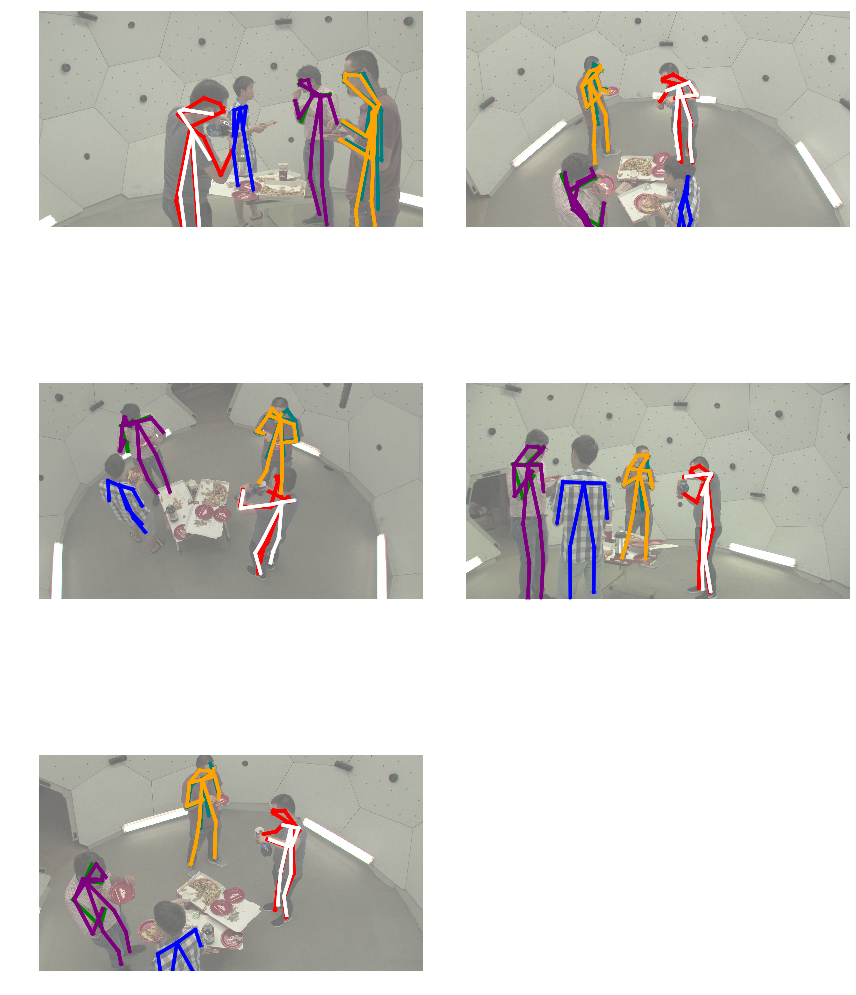

In [82]:
from mvpose.baseline.baseline import estimate

_start = time()
Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)
Y = cmu_panoptic.transform_y(Y)
predictions = pe.predict(Im, 'cvpr_cmu' + seq_name, FRAME)

# -- remove cameras --
# Im = Im[0:3]
# Y = Y[0:3]
# predictions = predictions[0:3]
# Calib = Calib[0:3]
# -- {end} remove cameras --


humans, H = estimate(Calib, predictions, epi_threshold=40, 
                     get_hypothesis=True)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(12,16))

print('#d', len(humans))
colors = ['red', 'blue', 'green', 'teal', 'orange', 'white', 'purple']

for cid, cam in enumerate(Calib):
    ax = fig.add_subplot(3, 2, 1+cid)
    ax.axis('off')
    im = Im[cid]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, hyp in enumerate(humans):
        draw_mscoco_human(ax, hyp, cam, alpha=0.5,
                          color=colors[pid], linewidth=3)

# ===
closest = find_closest_detections_to_gt(Y, humans)
print('')
print('-- best fit --')
print(closest)
print('\tmin: ' + str(np.min(closest))) 
print('\tmax: ' + str(np.max(closest)))
print('\tavg: ' + str(np.mean(closest)))

print('')
print_pcp(*calculate_pcp_score(Y, humans))

print('\n(BASELINE)')
    
plt.tight_layout()
plt.show()

In [7]:
#valid_frames = list(range(8630, 9230, 4))
valid_frames = list(range(8630, 8642, 4))
print('#frames', len(valid_frames))

def handle_frame(frame):
    Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=frame)
    Y = cmu_panoptic.transform_y(Y)
    predictions = pe.predict(Im, 'cvpr_cmu' + seq_name, frame)
    humans, H = estimate(Calib, predictions, epi_threshold=40, 
                     get_hypothesis=True)
    
    return find_closest_detections_to_gt(Y, humans)
    
TOTAL = []
TOTAL_AVG = []
    
frame = 9100
_start = time()
scores = handle_frame(frame)
TOTAL.append(scores)
_end = time()
print('frame ' + str(frame) + ', elapsed', _end - _start)
    
# for frame in valid_frames:
#     _start = time()
#     scores = handle_frame(frame)
#     TOTAL.append(scores)
#     _end = time()
#     print('frame ' + str(frame) + ', elapsed', _end - _start)
    
print(TOTAL)

#frames 3
#gt: 6
#d: 6
frame 9100, elapsed 0.32266664505004883
[[31.832341648516252, 29.882793325502274, 17.248307912519866, 48.6260345241196, 24.85736414160319, 24.409751261459714]]


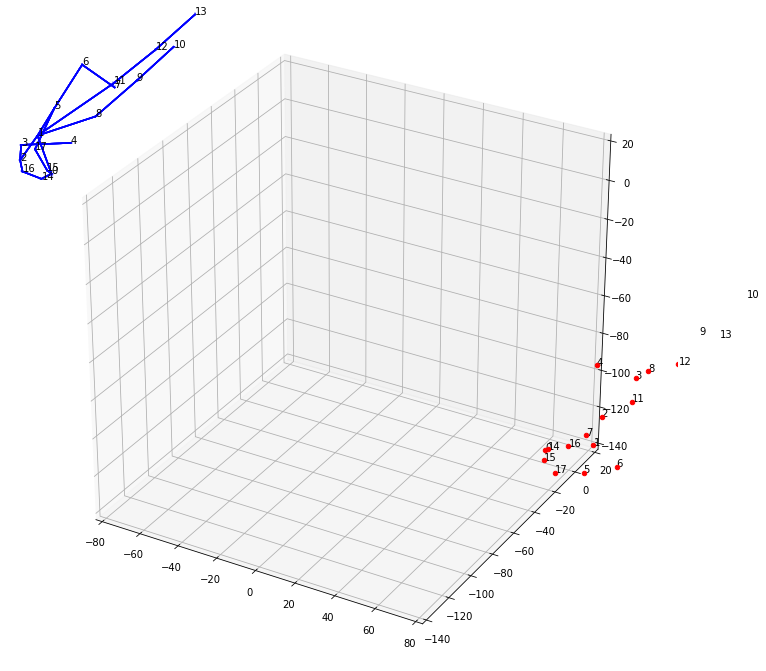

In [8]:
from mvpose.plot.limbs import draw_mscoco_human3d

Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=FRAME)
Y = cmu_panoptic.transform_y(Y)

from mpl_toolkits.mplot3d import Axes3D
item = Y[0][1][:, 0:3]
itemT = np.transpose(item)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# ---
ax.set_xlim([-80, 80])
ax.set_ylim([-140, 20])
ax.set_zlim([-140, 20])
#ax.scatter(item[:, 0], item[:, 1], item[:, 2])
draw_mscoco_human3d(ax, item, color='blue', alpha=0.3)

for idx, (x, y, z) in enumerate(item):
    ax.text( x, y, z, str(idx))

    
# ---
Hum = humans[0]
Hum
for jid, pt in enumerate(Hum):
    if pt is None:
        continue
    ax.scatter(*pt, color='red')
    ax.text(*pt, str(jid))
    
plt.show()

In [9]:
params = settings.get_settings(
    max_epi_distance=40, 
    scale_to_mm=10, 
    gp_max_radius=30,
    pp_conflict_overlap=0.6)

In [83]:
def handle(valid_frames, seq_name, PER_GTID_baseline, PER_GTID_model):
    global loader, params
    print('\n\n==============================')
    print('sequence:', seq_name)
    print('\t#frames:', len(valid_frames))
    print('==============================')
    
    for frame in valid_frames:
        _start = time()
        Im, Y, Calib = cmu_panoptic.get(root, seq_name, 
                                panels, nodes, frame=frame)
        Y = cmu_panoptic.transform_y(Y)
        
        # -- remove cameras --
        Im = Im[0:3]
        Y = Y[0:3]
        Calib = Calib[0:3]
        # -- {end} remove cameras --
        
        #----------------------
        # -- simple baseline --
        predictions = pe.predict(Im, 'cvpr_cmu' + seq_name, frame)
        
        # -- remove cameras --
        predictions = predictions[0:3]
        # -- {end} remove cameras --
        
        humans = estimate(Calib, predictions, epi_threshold=40)
        for larms, uarms, llegs, ulegs, gtid in zip(*calculate_pcp_score(Y, humans)):
            if not gtid in PER_GTID_baseline:
                PER_GTID_baseline[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            PER_GTID_baseline[gtid]['larms'].append(larms)
            PER_GTID_baseline[gtid]['uarms'].append(uarms)
            PER_GTID_baseline[gtid]['llegs'].append(llegs)
            PER_GTID_baseline[gtid]['ulegs'].append(ulegs)
            PER_GTID_baseline[gtid]['frame'].append(frame)
        
        #----------------------
        # ----- our model -----
        heatmaps, pafs = loader.load_confidence_map_and_paf(
            'cvpr2_cmu' + seq_name, Im, frame, dir=tmp)
        detections = pose.estimate(
            Calib, heatmaps, pafs, settings=params, debug=False)
        for larms, uarms, llegs, ulegs, gtid in zip(*calculate_pcp_score(Y, detections)):
            if not gtid in PER_GTID_model:
                PER_GTID_model[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            PER_GTID_model[gtid]['larms'].append(larms)
            PER_GTID_model[gtid]['uarms'].append(uarms)
            PER_GTID_model[gtid]['llegs'].append(llegs)
            PER_GTID_model[gtid]['ulegs'].append(ulegs)
            PER_GTID_model[gtid]['frame'].append(frame)
        
        _end = time()
        print("\t[" + seq_name + '] frame: %05d' % frame + ', |d|:', round(_end - _start, 3))
        
STEPS = 4

# ============

valid_frames = list(range(8630, 9230, STEPS))
seq_name = '160422_ultimatum1'

ULT_PER_GTID_baseline = {}
ULT_PER_GTID_model = {}

handle(valid_frames, seq_name, 
       ULT_PER_GTID_baseline, ULT_PER_GTID_model)

# ============

valid_frames = list(range(3250, 3850, STEPS))
seq_name = '160224_haggling1'

HAG_PER_GTID_baseline = {}
HAG_PER_GTID_model = {}

handle(valid_frames, seq_name, 
       HAG_PER_GTID_baseline, HAG_PER_GTID_model)

# ============

valid_frames = list(range(112, 712, STEPS))
seq_name = '160906_pizza1'

PIZ_PER_GTID_baseline = {}
PIZ_PER_GTID_model = {}

handle(valid_frames, seq_name, 
       PIZ_PER_GTID_baseline, PIZ_PER_GTID_model)



sequence: 160422_ultimatum1
	#frames: 150
	[160422_ultimatum1] frame: 08630, |d|: 14.371
	[160422_ultimatum1] frame: 08634, |d|: 13.645
	[160422_ultimatum1] frame: 08638, |d|: 13.62
	[160422_ultimatum1] frame: 08642, |d|: 13.786
	[160422_ultimatum1] frame: 08646, |d|: 13.818
	[160422_ultimatum1] frame: 08650, |d|: 13.8
	[160422_ultimatum1] frame: 08654, |d|: 13.701
	[160422_ultimatum1] frame: 08658, |d|: 13.503
	[160422_ultimatum1] frame: 08662, |d|: 13.523
	[160422_ultimatum1] frame: 08666, |d|: 13.3
	[160422_ultimatum1] frame: 08670, |d|: 13.571
	[160422_ultimatum1] frame: 08674, |d|: 14.008
	[160422_ultimatum1] frame: 08678, |d|: 14.047
	[160422_ultimatum1] frame: 08682, |d|: 13.995
	[160422_ultimatum1] frame: 08686, |d|: 14.025
	[160422_ultimatum1] frame: 08690, |d|: 13.969
	[160422_ultimatum1] frame: 08694, |d|: 14.117
	[160422_ultimatum1] frame: 08698, |d|: 14.009
	[160422_ultimatum1] frame: 08702, |d|: 14.101
	[160422_ultimatum1] frame: 08706, |d|: 14.166
	[160422_ultimatum1] 

	[160224_haggling1] frame: 03334, |d|: 14.896
	[160224_haggling1] frame: 03338, |d|: 14.619
	[160224_haggling1] frame: 03342, |d|: 14.259
	[160224_haggling1] frame: 03346, |d|: 14.162
	[160224_haggling1] frame: 03350, |d|: 14.149
	[160224_haggling1] frame: 03354, |d|: 14.335
	[160224_haggling1] frame: 03358, |d|: 14.267
	[160224_haggling1] frame: 03362, |d|: 14.613
	[160224_haggling1] frame: 03366, |d|: 14.595
	[160224_haggling1] frame: 03370, |d|: 14.327
	[160224_haggling1] frame: 03374, |d|: 14.658
	[160224_haggling1] frame: 03378, |d|: 14.878
	[160224_haggling1] frame: 03382, |d|: 14.657
	[160224_haggling1] frame: 03386, |d|: 14.618
	[160224_haggling1] frame: 03390, |d|: 14.631
	[160224_haggling1] frame: 03394, |d|: 14.86
	[160224_haggling1] frame: 03398, |d|: 14.439
	[160224_haggling1] frame: 03402, |d|: 14.777
	[160224_haggling1] frame: 03406, |d|: 14.739
	[160224_haggling1] frame: 03410, |d|: 14.416
	[160224_haggling1] frame: 03414, |d|: 14.402
	[160224_haggling1] frame: 03418, |

	[160906_pizza1] frame: 00316, |d|: 14.677
	[160906_pizza1] frame: 00320, |d|: 14.839
	[160906_pizza1] frame: 00324, |d|: 14.732
	[160906_pizza1] frame: 00328, |d|: 16.319
	[160906_pizza1] frame: 00332, |d|: 14.441
	[160906_pizza1] frame: 00336, |d|: 14.832
	[160906_pizza1] frame: 00340, |d|: 15.083
	[160906_pizza1] frame: 00344, |d|: 15.576
	[160906_pizza1] frame: 00348, |d|: 15.245
	[160906_pizza1] frame: 00352, |d|: 14.84
	[160906_pizza1] frame: 00356, |d|: 14.403
	[160906_pizza1] frame: 00360, |d|: 15.409
	[160906_pizza1] frame: 00364, |d|: 14.709
	[160906_pizza1] frame: 00368, |d|: 14.586
	[160906_pizza1] frame: 00372, |d|: 15.488
	[160906_pizza1] frame: 00376, |d|: 15.194
	[160906_pizza1] frame: 00380, |d|: 14.639
	[160906_pizza1] frame: 00384, |d|: 14.622
	[160906_pizza1] frame: 00388, |d|: 15.653
	[160906_pizza1] frame: 00392, |d|: 15.288
	[160906_pizza1] frame: 00396, |d|: 14.735
	[160906_pizza1] frame: 00400, |d|: 15.655
	[160906_pizza1] frame: 00404, |d|: 14.606
	[160906_piz

In [84]:
def plot_info(PER_GTID):
    total_avg = []
    for key, values in PER_GTID.items():
        print('actor ', key)
        print('\tuarms:', np.mean(values['uarms']))
        print('\tlarms:', np.mean(values['larms']))
        print('\tulegs:', np.mean(values['ulegs']))
        print('\tllegs:', np.mean(values['llegs']))
        avg = np.mean([
            np.mean(values['uarms']),
            np.mean(values['larms']),
            np.mean(values['ulegs']),
            np.mean(values['llegs'])
        ])
        total_avg.append(avg)
        print('\tavg:  ', avg)
    print('\navg*:  ', np.mean(total_avg))
    
print('\n\n==============================')
print('sequence:', '160422_ultimatum1')
print('==============================')
print('baseline:')
print('--------')
plot_info(ULT_PER_GTID_baseline)
print('\nmodel:')
print('--------')
plot_info(ULT_PER_GTID_model)

print('\n\n==============================')
print('sequence:', '160224_haggling1')
print('==============================')
print('baseline:')
print('--------')
plot_info(HAG_PER_GTID_baseline)
print('\nmodel:')
print('--------')
plot_info(HAG_PER_GTID_model)

print('\n\n==============================')
print('sequence:', '160906_pizza1')
print('==============================')
print('baseline:')
print('--------')
plot_info(PIZ_PER_GTID_baseline)
print('\nmodel:')
print('--------')
plot_info(PIZ_PER_GTID_model)



sequence: 160422_ultimatum1
baseline:
--------
actor  0
	uarms: 0.8566666666666667
	larms: 0.6766666666666666
	ulegs: 0.10666666666666667
	llegs: 0.06333333333333334
	avg:   0.4258333333333333
actor  1
	uarms: 0.11
	larms: 0.1
	ulegs: 0.1
	llegs: 0.08666666666666667
	avg:   0.09916666666666668
actor  2
	uarms: 0.5709219858156028
	larms: 0.549645390070922
	ulegs: 0.8652482269503546
	llegs: 0.6985815602836879
	avg:   0.6710992907801419

avg*:   0.3986997635933806

model:
--------
actor  0
	uarms: 0.8266666666666667
	larms: 0.7633333333333333
	ulegs: 0.31333333333333335
	llegs: 0.26
	avg:   0.5408333333333333
actor  1
	uarms: 0.14333333333333334
	larms: 0.13
	ulegs: 0.14
	llegs: 0.11333333333333333
	avg:   0.13166666666666665
actor  2
	uarms: 0.9113475177304965
	larms: 0.8439716312056738
	ulegs: 0.9219858156028369
	llegs: 0.7198581560283688
	avg:   0.849290780141844

avg*:   0.5072635933806146


sequence: 160224_haggling1
baseline:
--------
actor  0
	uarms: 0.64
	larms: 0.44
	ulegs: 0.9

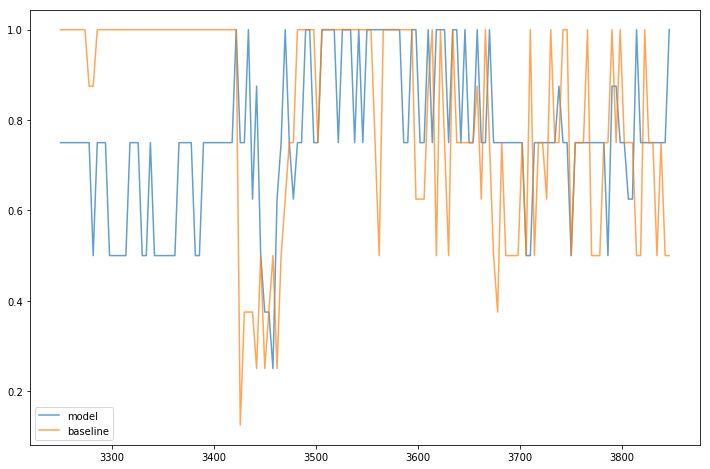

In [60]:
def get_avg_by_frame(PER_GTID, actor):
    FR_act = [frame for frame in PER_GTID[actor]['frame']]
    LA_act = np.array([frame for frame in PER_GTID[actor]['larms']])
    UA_act = np.array([frame for frame in PER_GTID[actor]['uarms']])
    LL_act = np.array([frame for frame in PER_GTID[actor]['llegs']])
    UL_act = np.array([frame for frame in PER_GTID[actor]['ulegs']])
    AV_act = (LA_act + UA_act + LL_act + LL_act) / 4
    return FR_act, AV_act

FR_act1, AV_act1 = get_avg_by_frame(HAG_PER_GTID_model, 0)
FR_act2, AV_act2 = get_avg_by_frame(HAG_PER_GTID_baseline, 0)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(FR_act1, AV_act1, alpha=0.7, label='model')
ax.plot(FR_act2, AV_act2, alpha=0.7, label='baseline')
plt.legend()
plt.show()

# REMEMBER RESULTS

## All images, epi=40

In [ ]:
# ==============================
# sequence: 160422_ultimatum1
# ==============================
# baseline:
# --------
# actor  0
# 	uarms: 0.9733333333333334
# 	larms: 0.89
# 	ulegs: 0.8766666666666667
# 	llegs: 0.87
# 	avg:   0.9025000000000001
# actor  1
# 	uarms: 0.38666666666666666
# 	larms: 0.33666666666666667
# 	ulegs: 0.15666666666666668
# 	llegs: 0.12666666666666668
# 	avg:   0.2516666666666667
# actor  2
# 	uarms: 0.9042553191489362
# 	larms: 0.875886524822695
# 	ulegs: 0.9397163120567376
# 	llegs: 0.9113475177304965
# 	avg:   0.9078014184397163
# actor  3
# 	uarms: 0.8527131782945736
# 	larms: 0.813953488372093
# 	ulegs: 0.8565891472868217
# 	llegs: 0.751937984496124
# 	avg:   0.8187984496124031
# actor  4
# 	uarms: 0.7563025210084033
# 	larms: 0.680672268907563
# 	ulegs: 0.4831932773109244
# 	llegs: 0.4327731092436975
# 	avg:   0.5882352941176471
# actor  5
# 	uarms: 0.85
# 	larms: 0.85
# 	ulegs: 0.8545454545454545
# 	llegs: 0.8545454545454545
# 	avg:   0.8522727272727273

# avg*:   0.7202124260181934

# model:
# --------
# actor  0
# 	uarms: 0.9166666666666666
# 	larms: 0.8433333333333334
# 	ulegs: 0.9733333333333334
# 	llegs: 0.9166666666666666
# 	avg:   0.9125
# actor  1
# 	uarms: 0.45
# 	larms: 0.32
# 	ulegs: 0.14666666666666667
# 	llegs: 0.12
# 	avg:   0.25916666666666666
# actor  2
# 	uarms: 0.9539007092198581
# 	larms: 0.9468085106382979
# 	ulegs: 0.950354609929078
# 	llegs: 0.9361702127659575
# 	avg:   0.946808510638298
# actor  3
# 	uarms: 0.9186046511627907
# 	larms: 0.6976744186046512
# 	ulegs: 0.9108527131782945
# 	llegs: 0.8255813953488372
# 	avg:   0.8381782945736435
# actor  4
# 	uarms: 0.9369747899159664
# 	larms: 0.8109243697478992
# 	ulegs: 0.5336134453781513
# 	llegs: 0.4411764705882353
# 	avg:   0.680672268907563
# actor  5
# 	uarms: 0.9272727272727272
# 	larms: 0.9227272727272727
# 	ulegs: 0.9636363636363636
# 	llegs: 0.9454545454545454
# 	avg:   0.9397727272727272

# avg*:   0.7628497446764829


# ==============================
# sequence: 160224_haggling1
# ==============================
# baseline:
# --------
# actor  0
# 	uarms: 0.9433333333333334
# 	larms: 0.87
# 	ulegs: 0.9666666666666667
# 	llegs: 0.73
# 	avg:   0.8775000000000001
# actor  1
# 	uarms: 1.0
# 	larms: 0.9966666666666667
# 	ulegs: 1.0
# 	llegs: 0.9866666666666667
# 	avg:   0.9958333333333333
# actor  2
# 	uarms: 0.6933333333333334
# 	larms: 0.6066666666666667
# 	ulegs: 0.71
# 	llegs: 0.6533333333333333
# 	avg:   0.6658333333333333

# avg*:   0.8463888888888889

# model:
# --------
# actor  0
# 	uarms: 0.9833333333333333
# 	larms: 0.9333333333333333
# 	ulegs: 0.8466666666666667
# 	llegs: 0.57
# 	avg:   0.8333333333333333
# actor  1
# 	uarms: 1.0
# 	larms: 0.98
# 	ulegs: 0.97
# 	llegs: 0.93
# 	avg:   0.9700000000000001
# actor  2
# 	uarms: 0.85
# 	larms: 0.7433333333333333
# 	ulegs: 0.4766666666666667
# 	llegs: 0.4666666666666667
# 	avg:   0.6341666666666667

# avg*:   0.8125


# ==============================
# sequence: 160906_pizza1
# ==============================
# baseline:
# --------
# actor  0
# 	uarms: 0.9933333333333333
# 	larms: 0.97
# 	ulegs: 1.0
# 	llegs: 0.9933333333333333
# 	avg:   0.9891666666666666
# actor  1
# 	uarms: 0.8233333333333334
# 	larms: 0.76
# 	ulegs: 0.88
# 	llegs: 0.74
# 	avg:   0.8008333333333333
# actor  2
# 	uarms: 0.87
# 	larms: 0.7266666666666667
# 	ulegs: 0.8933333333333333
# 	llegs: 0.7466666666666667
# 	avg:   0.8091666666666667
# actor  3
# 	uarms: 0.45
# 	larms: 0.1
# 	ulegs: 0.2733333333333333
# 	llegs: 0.016666666666666666
# 	avg:   0.21000000000000002
# actor  4
# 	uarms: 0.7009803921568627
# 	larms: 0.5294117647058824
# 	ulegs: 0.6274509803921569
# 	llegs: 0.36764705882352944
# 	avg:   0.5563725490196079

# avg*:   0.6731078431372548

# model:
# --------
# actor  0
# 	uarms: 0.9833333333333333
# 	larms: 0.9633333333333334
# 	ulegs: 0.9666666666666667
# 	llegs: 0.9566666666666667
# 	avg:   0.9675
# actor  1
# 	uarms: 0.98
# 	larms: 0.9433333333333334
# 	ulegs: 0.9433333333333334
# 	llegs: 0.7
# 	avg:   0.8916666666666666
# actor  2
# 	uarms: 0.7766666666666666
# 	larms: 0.69
# 	ulegs: 0.8633333333333333
# 	llegs: 0.76
# 	avg:   0.7725
# actor  3
# 	uarms: 0.83
# 	larms: 0.30666666666666664
# 	ulegs: 0.7133333333333334
# 	llegs: 0.27
# 	avg:   0.53
# actor  4
# 	uarms: 0.8284313725490197
# 	larms: 0.7401960784313726
# 	ulegs: 0.7450980392156863
# 	llegs: 0.5490196078431373
# 	avg:   0.715686274509804

# avg*:   0.7754705882352942